# Example Notebook for TAFT
## Time alignment for tiles 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from melp import Detector
import melp.taft

Welcome to JupyROOT 6.24/06


## Creating/Loading detector with misalignment

In [2]:
mu3e_detector = Detector.initFromROOT("run42_20000.root")
#mu3e_detector = Detector.initFromSave("calibrated_detector_tmp.taft")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  True
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [3]:
#mu3e_detector.save("test_detector_file")

In [4]:
melp.taft.select(mu3e_detector)

## Plotting time misalignment distribution

In [5]:
dt = []
for tile in mu3e_detector.TileDetector.tile:
    dt.append(mu3e_detector.TileDetector.tile[tile].dt_truth)

In [6]:
dt = np.array(dt)

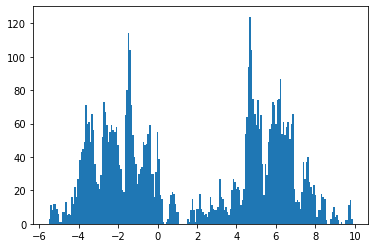

In [7]:
plt.hist(dt, bins=200)
plt.show()

In [8]:
#master_tile = mu3e_detector.TileDetector.tile[200000].dt_truth
#for tile_id in mu3e_detector.TileDetector.tile:
#    tile = mu3e_detector.TileDetector.tile[tile_id]
#    tile.dt_truth -= tile.dt_cal + master_tile
#    tile.dt_cal = 0.

In [9]:
#mu3e_detector.TileDetector.calibrated = False

# Calibrating Tile Detector

In [10]:
options = {
    "debug_station": 1,
    "tof": "advanced_new",
    "dt_mode": "median",
    "overwrite": False,
    "histo_options": (10000, -64, 64),
    "mean_threshold": 1
}

In [11]:
resid_z, resid_phi, cal_z, cal_phi = melp.taft.calibrate("merged.root", **options)

Using  median
Searching clusters. Progress:  100  % , Found:  62493722
Calculating absolute timing offsets to master tile: 200000
Calculating absolute timing offsets to master tile: 300000
Calibration finished
Elapsed time: 332.4584 seconds


/home/maximilian/Github/melp/melp/taft/calibrate.py:272: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")
/home/maximilian/Github/melp/melp/taft/calibrate.py:208: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")


In [12]:
#mu3e_detector.save("calibrated_detector_tmp_meadian.taft")

In [13]:
resid_z = np.array(resid_z)
resid_phi = np.array(resid_phi)

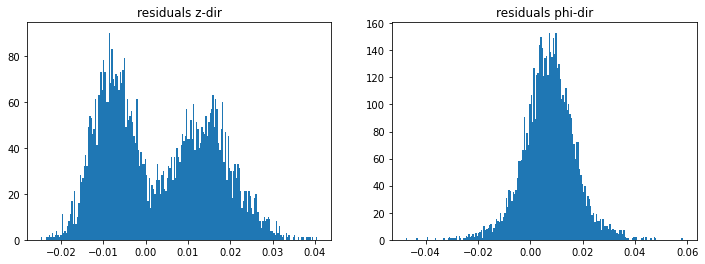

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(resid_z, bins=200)
axs[0].title.set_text("residuals z-dir")
axs[1].hist(resid_phi, bins=200)
axs[1].title.set_text("residuals phi-dir")
plt.show()

### small data sets results in empty histograms between some tiles
#### -> big jumps in dt

## Result for z-direction (station 1)

In [15]:
cal1 = {}
for phi_row in range(56):
    dt_truth = [0]
    for tile in range(0, 51):
        
        tile_id = 200000 + phi_row + tile * 56

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "right")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal1[phi_row] = np.array(dt_truth)

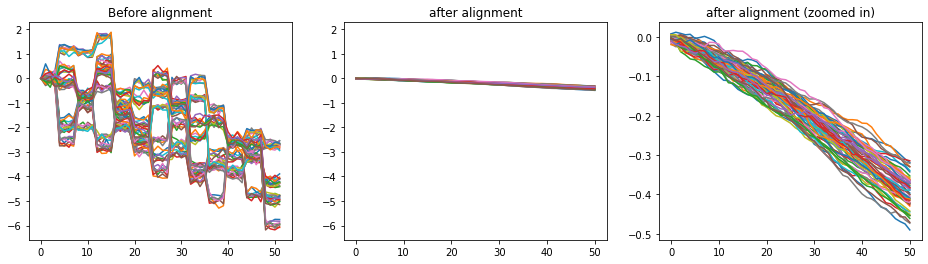

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal1:
    axs[0].plot(np.array(cal1[phi], dtype=object))

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_z:
    axs[1].plot(cal_z[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_z:
    axs[2].plot(cal_z[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

## Result for phi-direction

In [17]:
cal2 = {}
for z_column in range(52):
    dt_truth = [0]
    for tile in range(0, 56):
        
        tile_id = (200000 + z_column*56 + tile)

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "up")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal2[z_column] = np.array(dt_truth)

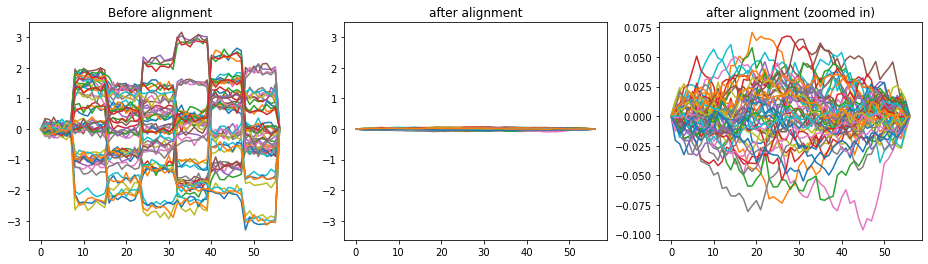

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal2:
    axs[0].plot(cal2[phi])

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_phi:
    axs[1].plot(cal_phi[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_phi:
    axs[2].plot(cal_phi[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

# Calibrated station

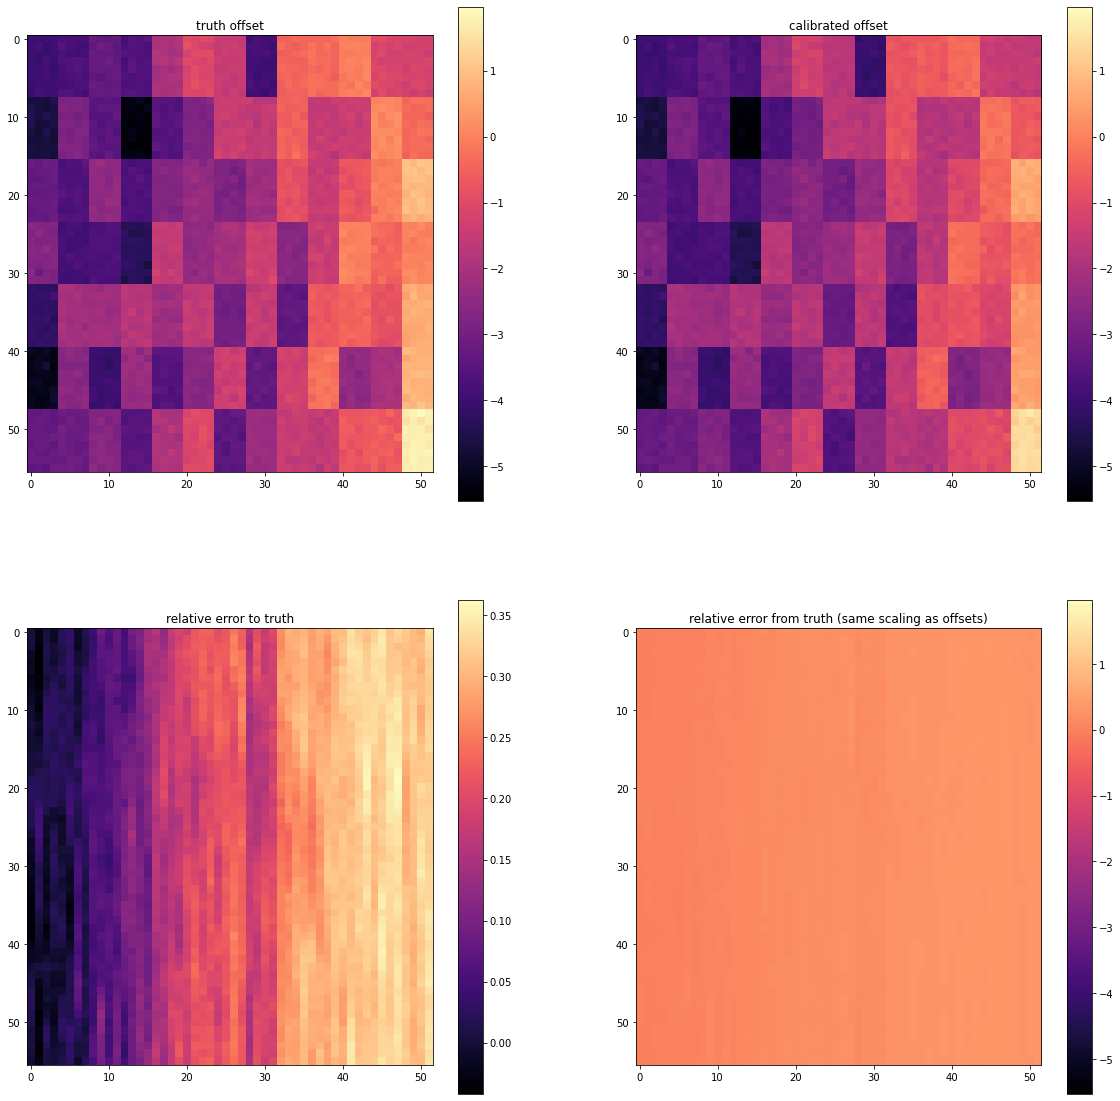

In [19]:
melp.taft.plot_station_calibration(mu3e_detector)